# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [9]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config and fiduc

In [10]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, lpt, nbody, cic_paint
from jaxpm.growth import growth_factor
kpks = []
a_obs = 1.

def evolve(model, params:tuple):
    cosmology, init = params

    # Create regular grid of particles
    q = jnp.indices(model.mesh_shape).reshape(3,-1).T

    # LPT displacement at a_lpt
    # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
    cosmology._workspace = {}  # HACK: temporary fix
    dq, p, f = lpt(cosmology, **init, positions=q, a=model.a_lpt, order=model.lpt_order)
    particles = jnp.stack([q + dq, p])

    # PM displacement from a_lpt to a_obs
    particles = nbody(cosmology, model.mesh_shape, particles, model.a_lpt, model.a_obs, model.snapshots)
    particles = particles[-1]

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), particles[0])
    return biased_mesh

for mesh_length in [64, 128, 256]:
    for lpt_order in [1, 2]:
        for pm in [0,1]:
            a_lpt = 0.1 if pm else a_obs
            config = {
                        'mesh_shape':3 * (mesh_length,),
                        'box_shape':3 * (640.,),
                        'a_lpt':a_lpt,
                        'a_obs':a_obs,
                        'lpt_order':lpt_order,
                        'precond':0,
                        'obs':'mesh'
                        }
            model = FieldLevelModel(**default_config | config)

            cosmology = Planck18()
            pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
            linmesh = jr.normal(jr.key(0), model.mesh_shape)
            linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
            init = {'init_mesh':linmesh}
            params = cosmology, init

            mesh = evolve(model, params)
            kpk = model.spectrum(mesh, comp=True)
            kpks.append(kpk)

            D1 = growth_factor(cosmology, jnp.atleast_1d(a_obs))
            kpklin = model.spectrum(jnp.fft.irfftn(linmesh * D1))
            kpks.append(kpklin)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

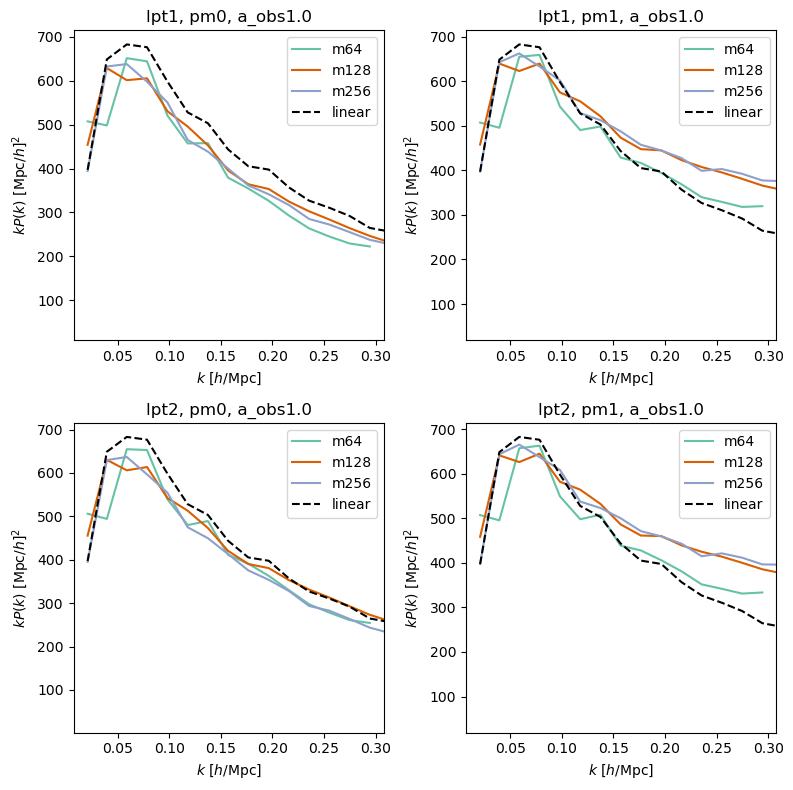

In [11]:
from montecosmo.plot import plot_pk, plot_trans, theme
theme()

plt.figure(figsize=(8, 8))
i_count = 0
for mesh_length in [64, 128, 256]:
    i_plt = 0
    for lpt_order in [1, 2]:
        for pm in [0,1]:
            kpk = kpks[i_count]
            kpklin = kpks[i_count+1]

            plt.subplot(2, 2, i_plt+1)
            plt.title(f'lpt{lpt_order}, pm{pm}, a_obs{a_obs}')

            # plot_trans(kpk[0], (kpk[1]/kpklin[1])**.5, label=f'm{mesh_length}')
            
            plot_pk(*kpk, label=f'm{mesh_length}')
            if i_count>15:
                plot_pk(*kpklin, 'k--', label='linear')
            
            plt.xlim(*plt.xlim())
        
            plt.legend()
            i_count += 2
            i_plt += 1
plt.tight_layout()

## Run

### NUTS, HMC

In [ ]:
def get_mcmc(model, config):
    n_samples = config['n_samples']
    n_chains = config['n_chains']
    max_tree_depth = config['max_tree_depth']
    target_accept_prob = config['target_accept_prob']
    name = config['sampler']
    
    if name == "NUTS":
        kernel = infer.NUTS(
            model=model,
            # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
            step_size=1e-5, 
            max_tree_depth=max_tree_depth,
            target_accept_prob=target_accept_prob,)
        
    elif name == "HMC":
        kernel = infer.HMC(
            model=model,
            # init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
            step_size=1e-5, 
            # Rule of thumb (2**max_tree_depth-1)*step_size_NUTS/(2 to 4), compare with default 2pi.
            trajectory_length= 1023 * 1e-3 / 4, 
            target_accept_prob=target_accept_prob,)

    mcmc = infer.MCMC(
        sampler=kernel,
        num_warmup=n_samples,
        num_samples=n_samples, # for each run
        num_chains=n_chains,
        chain_method="vectorized",
        progress_bar=True,)
    
    return mcmc

# print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
# invmm = list(last_state.adapt_state.inverse_mass_matrix.values())[0][0]
# invmm.min(),invmm.max(),invmm.mean(),invmm.std()

# Init params
# init_model = model.copy()
# init_model.partial(temp=1e-2)
# init_params_ = init_model.predict(samples=n_chains)

In [ ]:
continue_run = False
if continue_run:
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()
    mcmc = get_mcmc(model.model, mcmc_config)

    last_state = pload(save_path + "_last_state.p")
    mcmc.num_warmup = 0
    mcmc.post_warmup_state = last_state
    init_params_ = None
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.prior_loc, frombase=True)
    model.block()
    mcmc = get_mcmc(model.model, mcmc_config)
    
    print("Init params")
    init_params_ = jit(vmap(model.init_model))(jr.split(jr.key(43), mcmc_config['n_chains']))
    init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
    mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
    
    print("mean_acc_prob:", mcmc.last_state.mean_accept_prob, "\nss:", mcmc.last_state.adapt_state.step_size)
    init_params_ |= mcmc.last_state.z
    print(init_params_.keys())

    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()
    mcmc = get_mcmc(model.model, mcmc_config)

In [ ]:
mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)

In [ ]:
# model.reset()
# model.condition({'obs': truth['obs']})
# model.block()
# mcmc = get_mcmc(model.model, mcmc_config)
# init_params_ = {k+'_': jnp.broadcast_to(truth[k+'_'], (mcmc_config['n_chains'], *jnp.shape(truth[k+'_']))) for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}

# mcmc_runned = sample_and_save(mcmc, mcmc_config['n_runs'], save_path, extra_fields=['num_steps'], init_params=init_params_)